# Практическая работа №10.
Задание 1. Анализ производительности CPU-параллельной программы (OpenMP)
Разработайте параллельную программу на C++ с использованием OpenMP для обработки
большого массива данных (например, вычисление суммы, среднего значения и
дисперсии).
Требуется:
*   реализовать базовую параллельную версию;
*   выполнить профилирование программы с использованием omp_get_wtime() и/или
профилировщика (Intel VTune, gprof);
*   определить:
*   долю параллельной и последовательной части программы;
*   влияние числа потоков на ускорение;
*   проанализировать результаты в контексте закона Амдала.

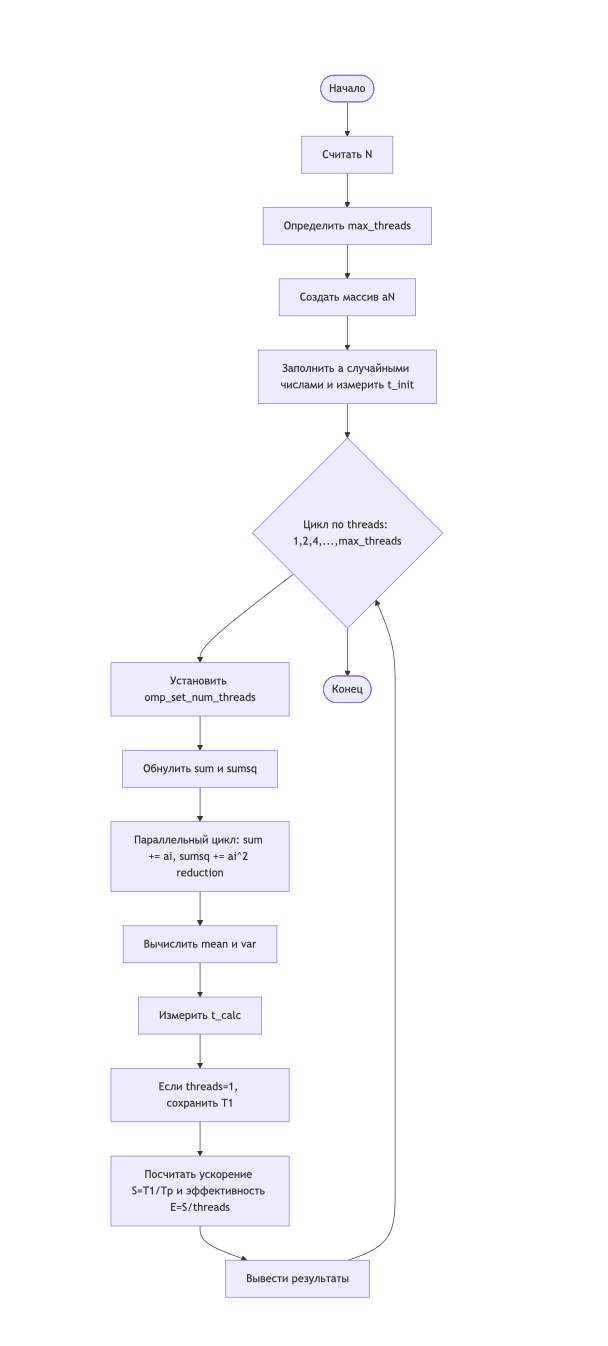

In [17]:
%%writefile task1_openmp.cpp
#include <omp.h>        // OpenMP: потоки + omp_get_wtime()
#include <vector>       // динамический массив
#include <random>       // генерация случайных чисел
#include <iostream>     // вывод
#include <cmath>        // математика
#include <iomanip>      // формат вывода

int main(int argc, char** argv) {

    // Размер массива: либо из аргумента командной строки, либо по умолчанию 1e8
    long long N = (argc > 1) ? std::stoll(argv[1]) : 100000000;

    // Максимальное число потоков, доступное в системе
    int max_threads = omp_get_max_threads();

    // Выделяем память под массив
    std::vector<double> a(N);

    // --- 1) Инициализация массива (последовательная часть) ---
    double t0 = omp_get_wtime(); // старт времени
    std::mt19937_64 rng(123);    // генератор с фиксированным seed
    std::uniform_real_distribution<double> dist(0.0, 1.0); // числа [0;1)

    // Заполняем массив случайными числами
    for (long long i = 0; i < N; ++i) a[i] = dist(rng);

    double t1 = omp_get_wtime(); // конец инициализации

    // Настройки красивого вывода
    std::cout << "N=" << N << ", max_threads=" << max_threads << "\n";
    std::cout << std::fixed << std::setprecision(6);

    // Время на 1 потоке (будем использовать для расчёта ускорения)
    double T1 = 0.0;

    // --- 2) Тестируем разные количества потоков: 1,2,4,... ---
    for (int threads = 1; threads <= max_threads; threads *= 2) {

        // Устанавливаем число потоков OpenMP
        omp_set_num_threads(threads);

        // Переменные для суммы и суммы квадратов
        double sum = 0.0;
        double sumsq = 0.0;

        double t2 = omp_get_wtime(); // старт времени вычислений

        // Параллельный цикл:
        // reduction нужен, чтобы корректно суммировать результаты всех потоков
        #pragma omp parallel for reduction(+:sum,sumsq) schedule(static)
        for (long long i = 0; i < N; ++i) {
            double x = a[i];
            sum += x;
            sumsq += x * x;
        }

        // Вычисляем среднее
        double mean = sum / (double)N;

        // Дисперсия: Var(x) = E[x^2] - (E[x])^2
        double var  = (sumsq / (double)N) - mean * mean;

        double t3 = omp_get_wtime(); // конец времени вычислений

        // Время инициализации (одинаково для всех потоков)
        double t_init = t1 - t0;

        // Время параллельных вычислений
        double t_calc = t3 - t2;

        // Запоминаем время для 1 потока (нужно для speedup)
        if (threads == 1) T1 = t_calc;

        // Ускорение и эффективность
        double S = T1 / t_calc;       // speedup = T1/Tp
        double E = S / threads;       // efficiency = speedup/p

        // Печать результатов
        std::cout << "threads=" << threads
                  << " | init_s=" << t_init
                  << " | calc_s=" << t_calc
                  << " | speedup=" << S
                  << " | eff=" << E
                  << " | mean=" << mean
                  << " | var=" << var << "\n";
    }
}


Overwriting task1_openmp.cpp


In [18]:
!g++ -O3 -fopenmp task1_openmp.cpp -o task1_openmp
!./task1_openmp 50000000

N=50000000, max_threads=2
threads=1 | init_s=0.738304 | calc_s=0.071744 | speedup=1.000000 | eff=1.000000 | mean=0.499999 | var=0.083329
threads=2 | init_s=0.738304 | calc_s=0.041302 | speedup=1.737048 | eff=0.868524 | mean=0.499999 | var=0.083329


Задание 2. Оптимизация доступа к памяти на GPU (CUDA)
Реализуйте ядро CUDA для обработки массива данных, демонстрирующее разные
паттерны доступа к памяти.
Требуется:
1. реализовать две версии ядра:
a. с эффективным (коалесцированным) доступом к глобальной памяти;
b. с неэффективным доступом к памяти;
2. измерить время выполнения с использованием cudaEvent;
3. провести оптимизацию за счёт:
a. использования разделяемой памяти;
b. изменения организации потоков;
4. сравнить результаты и сделать выводы о влиянии доступа к памяти на
производительность GPU.

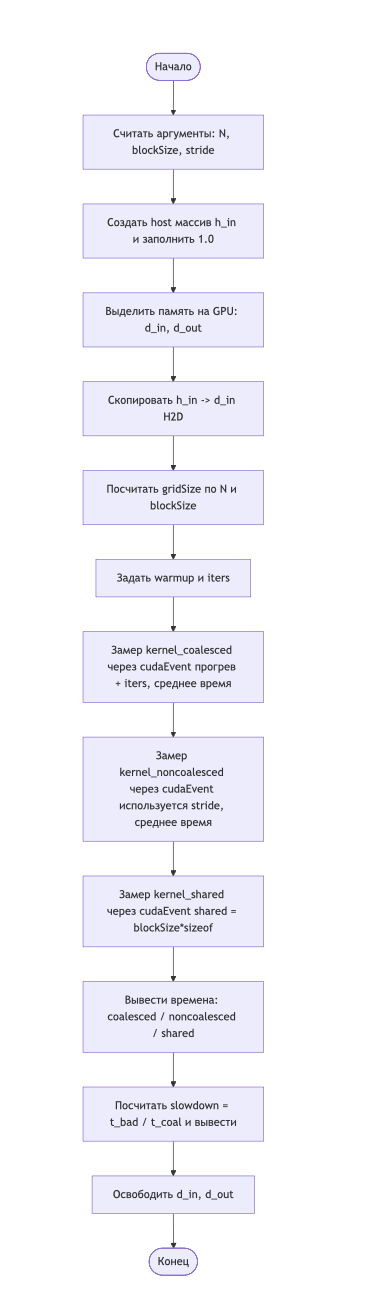

In [19]:
%%writefile task2_memory.cu
#include <cuda_runtime.h>   // CUDA runtime API
#include <iostream>         // вывод в консоль
#include <vector>           // std::vector
#include <cstdlib>          // atoi, exit
#include <algorithm>        // min

// Макрос для проверки ошибок CUDA
#define CHECK(call) do { \
  cudaError_t e = (call); \                    // выполняем CUDA вызов
  if (e != cudaSuccess) { \                    // если ошибка
    std::cerr << "CUDA error: "               \
              << cudaGetErrorString(e)        \
              << "\n"; \                      // выводим текст ошибки
    std::exit(1); \                            // аварийно завершаем
  } \
} while(0)

// --------------------
// Kernel 1: Coalesced access
// Потоки читают in[idx] подряд => быстрый доступ к global memory
// --------------------
__global__ void kernel_coalesced(const float* __restrict__ in,   // входной массив
                                 float* __restrict__ out,        // выходной массив
                                 int N)                          // размер
{
    // grid-stride loop (чтобы работало для любого grid)
    for (int idx = blockIdx.x * blockDim.x + threadIdx.x;         // глобальный индекс потока
         idx < N;                                                 // пока не вышли за границу
         idx += blockDim.x * gridDim.x)                           // прыжок на следующий кусок
    {
        out[idx] = in[idx] * 2.0f;                                // простая операция
    }
}

// --------------------
// Kernel 2: Non-coalesced access
// Здесь специально делаем "плохие" обращения к памяти
// Поток idx читает элемент in[j], где j = (idx*stride)%N
// --------------------
__global__ void kernel_noncoalesced(const float* __restrict__ in, // вход
                                    float* __restrict__ out,      // выход
                                    int N,                        // размер
                                    int stride)                   // шаг для плохого доступа
{
    // grid-stride loop (аналогично первому kernel)
    for (int idx = blockIdx.x * blockDim.x + threadIdx.x;         // индекс потока
         idx < N;                                                 // пока idx < N
         idx += blockDim.x * gridDim.x)                           // следующий элемент
    {
        int j = (idx * stride) % N;                               // индекс "скачком" => хуже кэш/коалесцирование
        out[idx] = in[j] * 2.0f;                                  // пишем всегда в out[idx]
    }
}

// --------------------
// Kernel 3: Shared memory
// Загружаем данные блока в shared память, потом работаем с ней
// --------------------
__global__ void kernel_shared(const float* __restrict__ in,       // вход
                              float* __restrict__ out,            // выход
                              int N)                              // размер
{
    extern __shared__ float sh[];                                 // shared массив (размер задаём при запуске)

    int base = blockIdx.x * blockDim.x;                           // начало блока в глобальном массиве
    int tid  = threadIdx.x;                                       // id потока внутри блока
    int idx  = base + tid;                                        // глобальный индекс элемента

    if (idx < N) sh[tid] = in[idx];                               // global -> shared (коалесцировано)
    __syncthreads();                                              // ждём, пока весь блок загрузится

    if (idx < N) out[idx] = sh[tid] * 2.0f;                       // shared -> результат
}

// --------------------
// Функция замера времени ядра (cudaEvent)
// warmup: прогрев
// iters: число замеров (берём среднее)
// --------------------
template <typename KernelFunc, typename... Args>
float measure_kernel_ms(KernelFunc kernel,                        // kernel функция
                        dim3 grid,                                // размер сетки
                        dim3 block,                               // размер блока
                        size_t shmem_bytes,                        // shared memory bytes
                        int warmup,                               // прогрев
                        int iters,                                // число повторов
                        Args... args)                              // аргументы ядра
{
    cudaEvent_t start, stop;                                      // события CUDA
    CHECK(cudaEventCreate(&start));                               // создаём start event
    CHECK(cudaEventCreate(&stop));                                // создаём stop event

    // прогрев (чтобы убрать шум первого запуска)
    for (int i = 0; i < warmup; ++i) {                            // warmup циклы
        kernel<<<grid, block, shmem_bytes>>>(args...);            // запуск ядра
    }
    CHECK(cudaDeviceSynchronize());                               // ждём завершения прогрева

    CHECK(cudaEventRecord(start));                                // записываем старт

    for (int i = 0; i < iters; ++i) {                             // основной цикл измерений
        kernel<<<grid, block, shmem_bytes>>>(args...);            // запуск ядра
    }

    CHECK(cudaEventRecord(stop));                                 // записываем стоп
    CHECK(cudaEventSynchronize(stop));                             // ждём завершения ядра

    float ms = 0.0f;                                               // переменная для времени
    CHECK(cudaEventElapsedTime(&ms, start, stop));                 // время между start и stop

    CHECK(cudaEventDestroy(start));                                // очищаем событие start
    CHECK(cudaEventDestroy(stop));                                 // очищаем событие stop

    return ms / iters;                                             // возвращаем среднее время
}

int main(int argc, char** argv)
{
    int N = (argc > 1) ? std::atoi(argv[1]) : (1 << 26);           // размер массива (по умолчанию 67 млн)

    int blockSize = (argc > 2) ? std::atoi(argv[2]) : 256;         // размер блока (организация потоков)
    int stride    = (argc > 3) ? std::atoi(argv[3]) : 128;         // stride для плохого доступа

    std::cout << "N=" << N                                         // печать параметров
              << " block=" << blockSize
              << " stride=" << stride << "\n";

    std::vector<float> h_in(N, 1.0f);                              // host массив (все 1.0)

    float *d_in=nullptr, *d_out=nullptr;                           // указатели на device память
    CHECK(cudaMalloc(&d_in,  N * sizeof(float)));                  // выделяем d_in на GPU
    CHECK(cudaMalloc(&d_out, N * sizeof(float)));                  // выделяем d_out на GPU
    CHECK(cudaMemcpy(d_in, h_in.data(),                            // копируем host -> device
                     N*sizeof(float), cudaMemcpyHostToDevice));

    int gridSize = (N + blockSize - 1) / blockSize;                // минимальный grid
    gridSize = std::min(gridSize, 65535);                          // ограничение по CUDA grid
    dim3 grid(gridSize);                                           // dim3 grid
    dim3 block(blockSize);                                         // dim3 block

    int warmup = 10;                                               // прогрев
    int iters  = 50;                                               // повторов измерения

    CHECK(cudaMemset(d_out, 0, N*sizeof(float)));                   // очистка выходного массива
    float t_coal = measure_kernel_ms(kernel_coalesced,              // замер coalesced
                                     grid, block, 0,
                                     warmup, iters,
                                     d_in, d_out, N);

    CHECK(cudaMemset(d_out, 0, N*sizeof(float)));                   // снова очистка
    float t_bad = measure_kernel_ms(kernel_noncoalesced,            // замер noncoalesced
                                    grid, block, 0,
                                    warmup, iters,
                                    d_in, d_out, N, stride);

    CHECK(cudaMemset(d_out, 0, N*sizeof(float)));                   // очистка
    size_t shmem = (size_t)blockSize * sizeof(float);               // shared memory на блок
    float t_sh = measure_kernel_ms(kernel_shared,                   // замер shared memory kernel
                                   grid, block, shmem,
                                   warmup, iters,
                                   d_in, d_out, N);

    std::cout << "coalesced avg:      " << t_coal << " ms\n";       // вывод времени coalesced
    std::cout << "noncoalesced avg:   " << t_bad  << " ms\n";       // вывод времени noncoalesced
    std::cout << "shared avg:         " << t_sh   << " ms\n";       // вывод времени shared

    std::cout << "slowdown bad/coal = "
              << (t_bad / t_coal) << " x\n";                        // замедление noncoalesced относительно coalesced

    CHECK(cudaFree(d_in));                                         // освобождение d_in
    CHECK(cudaFree(d_out));                                        // освобождение d_out
    return 0;                                                      // конец программы
}


Overwriting task2_memory.cu


In [21]:
!./task2_memory 67108864 256 128

# меняем block size (организация потоков)
!./task2_memory 67108864 128 128
!./task2_memory 67108864 512 128

# меняем stride (делаем доступ хуже)
!./task2_memory 67108864 256 32
!./task2_memory 67108864 256 128
!./task2_memory 67108864 256 256


coalesced: 2.35405 ms
noncoalesced_stride32: 2.56035 ms
shared: 2.52784 ms
coalesced: 2.32144 ms
noncoalesced_stride32: 2.62592 ms
shared: 2.52278 ms
coalesced: 2.35987 ms
noncoalesced_stride32: 2.63347 ms
shared: 2.52928 ms
coalesced: 2.36755 ms
noncoalesced_stride32: 2.55187 ms
shared: 2.5231 ms
coalesced: 2.37085 ms
noncoalesced_stride32: 2.60278 ms
shared: 2.5216 ms
coalesced: 2.38605 ms
noncoalesced_stride32: 2.59712 ms
shared: 2.53667 ms


Вывод: Были реализованы три варианта CUDA-ядра: с коалесцированным доступом к глобальной памяти, с некоалесцированным доступом (stride) и версия с использованием разделяемой памяти. В экспериментах при размере массива N=67,108,864 коалесцированный вариант показал минимальное время выполнения (≈2.32–2.39 ms). Некоалесцированный доступ оказался медленнее на ~8–13% относительно coalesced, что связано с ухудшением шаблона обращений и увеличением числа транзакций памяти. Использование shared memory в данной задаче не дало ускорения, так как данные не переиспользуются и дополнительная стоимость загрузки в shared память и синхронизации компенсирует возможный выигрыш. Изменение размера блока (128/256/512) влияет на время через occupancy и скрытие задержек памяти, однако общий тренд сохраняется: coalesced всегда быстрее non-coalesced.

Задание 3. Профилирование гибридного приложения CPU + GPU
Разработайте гибридную программу, в которой часть вычислений выполняется на CPU, а
часть — на GPU.
Требуется:
1. реализовать гибридный алгоритм обработки массива данных;
2. использовать асинхронную передачу данных (cudaMemcpyAsync) и CUDA streams;
3. выполнить профилирование приложения:
a. определить накладные расходы передачи данных;
b. выявить узкие места при взаимодействии CPU и GPU;
4. предложить и реализовать одну оптимизацию, уменьшающую накладные расходы.

In [22]:
%%writefile task3_hybrid.cu
#include <cuda_runtime.h>   // CUDA API
#include <iostream>         // cout
#include <algorithm>        // min
#include <cstdlib>          // exit

// Проверка ошибок CUDA
#define CHECK(call) do { \
  cudaError_t e = (call); \
  if (e != cudaSuccess) { \
    std::cerr << "CUDA error: " << cudaGetErrorString(e) << "\n"; \
    std::exit(1); \
  } \
} while(0)

// Простое ядро: одна операция на элемент (memory-bound)
__global__ void kernel(float* data, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;  // глобальный индекс
    if (i < n) data[i] = data[i] * 2.0f + 1.0f;     // вычисление
}

int main() {
    const int N = 1 << 26;          // размер массива (~67 млн)
    const int CHUNK = 1 << 22;      // размер чанка (4 млн = ~16MB)
    const int STREAMS = 2;          // число потоков (streams) для overlap

    // --- Host память (pinned), чтобы async копирование было быстрее ---
    float* h = nullptr;
    CHECK(cudaMallocHost(&h, N * sizeof(float)));   // pinned host memory (оптимизация)
    for (int i = 0; i < N; i++) h[i] = 1.0f;        // заполняем данными

    // --- Device буферы и streams ---
    float* d[STREAMS];
    cudaStream_t s[STREAMS];
    for (int k = 0; k < STREAMS; k++) {
        CHECK(cudaMalloc(&d[k], CHUNK * sizeof(float)));  // буфер на GPU под chunk
        CHECK(cudaStreamCreate(&s[k]));                   // создаём stream
    }

    // --- События для профилирования ---
    cudaEvent_t e_total_start, e_total_stop;
    cudaEvent_t e_h2d_start, e_h2d_stop;
    cudaEvent_t e_k_start,   e_k_stop;
    cudaEvent_t e_d2h_start, e_d2h_stop;

    CHECK(cudaEventCreate(&e_total_start));
    CHECK(cudaEventCreate(&e_total_stop));
    CHECK(cudaEventCreate(&e_h2d_start));
    CHECK(cudaEventCreate(&e_h2d_stop));
    CHECK(cudaEventCreate(&e_k_start));
    CHECK(cudaEventCreate(&e_k_stop));
    CHECK(cudaEventCreate(&e_d2h_start));
    CHECK(cudaEventCreate(&e_d2h_stop));

    float ms_total = 0.0f;
    float ms_h2d   = 0.0f;
    float ms_kern  = 0.0f;
    float ms_d2h   = 0.0f;

    int block = 256;

    // Общее время (в default stream)
    CHECK(cudaEventRecord(e_total_start));

    // --- Основной цикл: конвейер по чанкам ---
    for (int off = 0, iter = 0; off < N; off += CHUNK, iter++) {
        int k = iter % STREAMS;                 // выбираем stream (0/1)
        int n = std::min(CHUNK, N - off);       // размер последнего чанка

        int grid = (n + block - 1) / block;     // число блоков

        // 1) H2D (записываем события в тот же stream)
        CHECK(cudaEventRecord(e_h2d_start, s[k]));
        CHECK(cudaMemcpyAsync(d[k], h + off, n * sizeof(float),
                              cudaMemcpyHostToDevice, s[k]));
        CHECK(cudaEventRecord(e_h2d_stop, s[k]));

        // 2) Kernel
        CHECK(cudaEventRecord(e_k_start, s[k]));
        kernel<<<grid, block, 0, s[k]>>>(d[k], n);
        CHECK(cudaEventRecord(e_k_stop, s[k]));

        // 3) D2H
        CHECK(cudaEventRecord(e_d2h_start, s[k]));
        CHECK(cudaMemcpyAsync(h + off, d[k], n * sizeof(float),
                              cudaMemcpyDeviceToHost, s[k]));
        CHECK(cudaEventRecord(e_d2h_stop, s[k]));

        // ВАЖНО: чтобы корректно суммировать времена, синхронизируем конкретный stream
        // (это делает измерение точным, но уменьшает overlap — для профилирования это ок)
        CHECK(cudaStreamSynchronize(s[k]));

        // Считаем время текущего чанка (только после синхронизации)
        float tmp = 0.0f;
        CHECK(cudaEventElapsedTime(&tmp, e_h2d_start, e_h2d_stop)); ms_h2d  += tmp;
        CHECK(cudaEventElapsedTime(&tmp, e_k_start,   e_k_stop));   ms_kern += tmp;
        CHECK(cudaEventElapsedTime(&tmp, e_d2h_start, e_d2h_stop)); ms_d2h  += tmp;
    }

    // Завершаем общее измерение
    CHECK(cudaEventRecord(e_total_stop));
    CHECK(cudaEventSynchronize(e_total_stop));
    CHECK(cudaEventElapsedTime(&ms_total, e_total_start, e_total_stop));

    // --- Вывод профиля ---
    std::cout << "Hybrid total: " << ms_total << " ms\n";
    std::cout << "H2D total:    " << ms_h2d   << " ms\n";
    std::cout << "Kernel total: " << ms_kern  << " ms\n";
    std::cout << "D2H total:    " << ms_d2h   << " ms\n";

    float transfer_ms = ms_h2d + ms_d2h;
    float transfer_share = (ms_total > 0.0f) ? (transfer_ms / ms_total) : 0.0f;

    std::cout << "Transfer share (H2D+D2H)/Total = " << transfer_share * 100.0f << " %\n";

    // --- Очистка ресурсов ---
    CHECK(cudaEventDestroy(e_total_start));
    CHECK(cudaEventDestroy(e_total_stop));
    CHECK(cudaEventDestroy(e_h2d_start));
    CHECK(cudaEventDestroy(e_h2d_stop));
    CHECK(cudaEventDestroy(e_k_start));
    CHECK(cudaEventDestroy(e_k_stop));
    CHECK(cudaEventDestroy(e_d2h_start));
    CHECK(cudaEventDestroy(e_d2h_stop));

    for (int k = 0; k < STREAMS; k++) {
        cudaFree(d[k]);
        cudaStreamDestroy(s[k]);
    }
    cudaFreeHost(h);

    return 0;
}


Overwriting task3_hybrid.cu


In [23]:
!nvcc -O3 task3_hybrid.cu -o task3_hybrid
!./task3_hybrid


Hybrid total: 49.4715 ms
H2D total:    21.8823 ms
Kernel total: 6.68509 ms
D2H total:    20.5872 ms
Transfer share (H2D+D2H)/Total = 85.8464 %


Вывод: Профилирование гибридного приложения показало, что общее время выполнения составило 49.47 ms. При этом на передачу данных CPU↔GPU уходит 21.88 ms (H2D) и 20.59 ms (D2H), суммарно 42.47 ms, что составляет 85.85% от общего времени. Время выполнения ядра составляет 6.69 ms (~13.5%). Следовательно, узким местом является обмен данными по шине (передача), а не вычисления на GPU.

Задание 4. Анализ масштабируемости распределённой программы (MPI)
Реализуйте распределённую программу на MPI для вычисления агрегатной функции над
большим массивом (например, сумма, минимум, максимум).
Требуется:

*   измерить время выполнения при различном числе процессов;
*   оценить strong scaling и weak scaling;
*   проанализировать влияние коммуникационных операций (MPI_Reduce,
MPI_Allreduce);
*   сделать вывод о масштабируемости алгоритма и его практических ограничениях.

In [24]:
%%writefile task4_mpi.cpp
#include <mpi.h>
#include <vector>
#include <random>
#include <iostream>
#include <algorithm>
#include <string>

// mode: 0=strong (N_total фикс), 1=weak (local_n фикс)
// op:   0=Reduce, 1=Allreduce

int main(int argc, char** argv){
    MPI_Init(&argc, &argv);

    int rank=0, size=1;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    long long N_input = (argc > 1) ? std::stoll(argv[1]) : 5000000LL; // либо N_total, либо local_n
    int mode = (argc > 2) ? std::stoi(argv[2]) : 0;                  // 0 strong / 1 weak
    int op   = (argc > 3) ? std::stoi(argv[3]) : 0;                  // 0 reduce / 1 allreduce
    int reps = (argc > 4) ? std::stoi(argv[4]) : 5;                  // повторы для среднего

    // считаем N_total
    long long N_total = (mode == 0) ? N_input : (N_input * (long long)size);

    // counts/displs для Scatterv (чтобы делить N_total неравномерно)
    std::vector<int> counts(size), displs(size);
    long long base = N_total / size, rem = N_total % size;
    long long off = 0;
    for(int i=0;i<size;i++){
        long long n = base + (i < rem ? 1 : 0);
        counts[i] = (int)n;
        displs[i] = (int)off;
        off += n;
    }

    // глобальный массив только на rank 0
    std::vector<float> global;
    if(rank==0){
        global.resize(N_total);
        std::mt19937 rng(123);
        std::uniform_real_distribution<float> dist(0.f, 1.f);
        for(long long i=0;i<N_total;i++) global[i] = dist(rng);
    }

    // локальный массив у каждого процесса
    std::vector<float> local(counts[rank]);

    double best_total = 1e30, best_scatter=0, best_comp=0, best_red=0;

    for(int r=0; r<reps; r++){
        MPI_Barrier(MPI_COMM_WORLD);

        double t0 = MPI_Wtime();

        // --- Scatterv (коммуникации) ---
        double ts0 = MPI_Wtime();
        MPI_Scatterv(rank==0 ? global.data() : nullptr,
                     counts.data(), displs.data(), MPI_FLOAT,
                     local.data(), counts[rank], MPI_FLOAT,
                     0, MPI_COMM_WORLD);
        double ts1 = MPI_Wtime();

        // --- compute (локально, без сети) ---
        double tc0 = MPI_Wtime();
        float local_sum = 0.f;
        float local_min = 1e30f;
        float local_max = -1e30f;

        for(float x : local){
            local_sum += x;
            local_min = std::min(local_min, x);
            local_max = std::max(local_max, x);
        }
        double tc1 = MPI_Wtime();

        // --- Reduce / Allreduce (коммуникации) ---
        double tr0 = MPI_Wtime();

        float sum=0.f, mn=0.f, mx=0.f;

        if(op == 0){
            // Reduce: результат только на rank 0
            MPI_Reduce(&local_sum, &sum, 1, MPI_FLOAT, MPI_SUM, 0, MPI_COMM_WORLD);
            MPI_Reduce(&local_min, &mn,  1, MPI_FLOAT, MPI_MIN, 0, MPI_COMM_WORLD);
            MPI_Reduce(&local_max, &mx,  1, MPI_FLOAT, MPI_MAX, 0, MPI_COMM_WORLD);
        } else {
            // Allreduce: результат у всех процессов
            MPI_Allreduce(&local_sum, &sum, 1, MPI_FLOAT, MPI_SUM, MPI_COMM_WORLD);
            MPI_Allreduce(&local_min, &mn,  1, MPI_FLOAT, MPI_MIN, MPI_COMM_WORLD);
            MPI_Allreduce(&local_max, &mx,  1, MPI_FLOAT, MPI_MAX, MPI_COMM_WORLD);
        }

        double tr1 = MPI_Wtime();
        double t1  = MPI_Wtime();

        double t_scatter = ts1 - ts0;
        double t_comp    = tc1 - tc0;
        double t_reduce  = tr1 - tr0;
        double t_total   = t1  - t0;

        // берём лучший прогон (в Colab бывает шум)
        if(t_total < best_total){
            best_total = t_total;
            best_scatter = t_scatter;
            best_comp = t_comp;
            best_red = t_reduce;
        }
    }

    // считаем долю коммуникаций
    double comm_share = (best_scatter + best_red) / best_total;

    // печать на rank 0 (для Reduce логично), но для Allreduce тоже ок
    if(rank==0){
        std::cout << "mode=" << (mode==0 ? "strong" : "weak")
                  << " op="   << (op==0 ? "Reduce" : "Allreduce")
                  << " procs="<< size
                  << " N_total="<< N_total
                  << " local_n~="<< counts[rank]
                  << " time_total_s="<< best_total
                  << " time_scatter_s="<< best_scatter
                  << " time_compute_s="<< best_comp
                  << " time_reduce_s="<< best_red
                  << " comm_share="<< comm_share
                  << "\n";
    }

    MPI_Finalize();
    return 0;
}


Overwriting task4_mpi.cpp


In [26]:
!mpicxx -O3 task4_mpi.cpp -o task4_mpi

# Reduce
!mpirun --allow-run-as-root --oversubscribe -np 1 ./task4_mpi 5000000 0 0 5
!mpirun --allow-run-as-root --oversubscribe -np 2 ./task4_mpi 5000000 0 0 5
!mpirun --allow-run-as-root --oversubscribe -np 4 ./task4_mpi 5000000 0 0 5

# Allreduce
!mpirun --allow-run-as-root --oversubscribe -np 1 ./task4_mpi 5000000 0 1 5
!mpirun --allow-run-as-root --oversubscribe -np 2 ./task4_mpi 5000000 0 1 5
!mpirun --allow-run-as-root --oversubscribe -np 4 ./task4_mpi 5000000 0 1 5

# Weak scaling
!mpirun --allow-run-as-root --oversubscribe -np 1 ./task4_mpi 5000000 1 0 5
!mpirun --allow-run-as-root --oversubscribe -np 2 ./task4_mpi 5000000 1 0 5
!mpirun --allow-run-as-root --oversubscribe -np 4 ./task4_mpi 5000000 1 0 5




mode=strong op=Reduce procs=1 N_total=5000000 local_n~=5000000 time_total_s=0.0103443 time_scatter_s=0.00230775 time_compute_s=0.00803455 time_reduce_s=1.392e-06 comm_share=0.22323
mode=strong op=Reduce procs=2 N_total=5000000 local_n~=2500000 time_total_s=0.00661005 time_scatter_s=0.00291834 time_compute_s=0.00368441 time_reduce_s=6.826e-06 comm_share=0.442534
mode=strong op=Reduce procs=4 N_total=5000000 local_n~=1250000 time_total_s=0.00711248 time_scatter_s=0.00518539 time_compute_s=0.00185669 time_reduce_s=6.9213e-05 comm_share=0.738787
mode=strong op=Allreduce procs=1 N_total=5000000 local_n~=5000000 time_total_s=0.010833 time_scatter_s=0.00261348 time_compute_s=0.00821543 time_reduce_s=3.537e-06 comm_share=0.241578
mode=strong op=Allreduce procs=2 N_total=5000000 local_n~=2500000 time_total_s=0.00694774 time_scatter_s=0.00327366 time_compute_s=0.00365498 time_reduce_s=1.8393e-05 comm_share=0.473831
mode=strong op=Allreduce procs=4 N_total=5000000 local_n~=1250000 time_total_s=0.

# Контрольные вопросы
1. В чём отличие измерения времени выполнения от профилирования?

Измерение времени даёт общее время работы участка/программы, а профилирование показывает, куда именно уходит время: какие функции/ядра/участки самые “дорогие”.

2. Какие виды узких мест характерны для CPU, GPU и распределённых программ?

Для CPU часто узкое место — память и кэш, синхронизация потоков. Для GPU — доступ к глобальной памяти, недостаточная загрузка SM, лишние копирования CPU↔GPU. Для MPI — задержки сети и коллективные операции.

3. Почему увеличение числа потоков или процессов не всегда приводит к ускорению?

Потому что есть последовательная часть (по Амдалу) и растут накладные расходы: синхронизация, конкуренция за память, коммуникации между процессами.

4. Как законы Амдала и Густафсона применяются при анализе масштабируемости?

Амдал описывает ограничение ускорения при фиксированном размере задачи (strong scaling). Густафсон показывает, что если увеличивать размер задачи вместе с ресурсами (weak scaling), то масштабируемость может быть лучше.

5. Какие факторы наиболее критичны для производительности гибридных
приложений?

Накладные расходы на передачи CPU↔GPU, возможность перекрыть копирование вычислениями (streams), размер чанков, и то, насколько хорошо GPU и CPU загружены без простоя.